In [5]:
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
from sagemaker.model_monitor import DataCaptureConfig
from datetime import datetime
import json

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-mnist"

role = sagemaker.get_execution_role()

## Set up model and data capture config

In [3]:
# Set to True to enable data capture
enable_capture = True

# Optional - Sampling percentage. Choose an integer value between 0 and 100
sampling_percentage = 100
# sampling_percentage = 30 # Example 30%

# Optional - The S3 URI of stored captured-data location
s3_capture_upload_path = 's3://'+bucket+'/sagemaker/DEMO-pytorch-mnist/datacaptured/'

# Specify either Input, Output or both. 
capture_modes = ['REQUEST','RESPONSE'] # In this example, we specify both
# capture_mode = ['REQUEST'] # Example - If you want to only capture input.

# Configuration object passed in when deploying Models to SM endpoints
data_capture_config = DataCaptureConfig(
    enable_capture = enable_capture, 
    sampling_percentage = sampling_percentage, # Optional
    destination_s3_uri = s3_capture_upload_path, # Optional
    capture_options = [{"CaptureMode": capture_mode} for capture_mode in capture_modes]
)

In [11]:
model = PyTorchModel(entry_point='mnist.py', 
                     model_data='s3://'+bucket+'/pytorch-training-2023-05-10-08-54-53-359/output/model.tar.gz', 
                     role=role, 
                     framework_version='1.5', 
                     py_version='py3')

In [12]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!

## Inference

### using sagemaker sdk

In [13]:
import gzip
import numpy as np
import random
import os

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

/tmp/ipykernel_28114/1427333465.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.array(mask, dtype=np.int)


In [14]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-8.72769836e+02  0.00000000e+00 -3.87456818e+02 -5.42923706e+02
  -5.19874329e+02 -5.33582764e+02 -4.84113525e+02 -5.39617126e+02
  -2.92903442e+02 -5.18819702e+02]
 [-8.51128906e+02 -4.88617371e+02 -3.27007141e+02 -3.44864075e+02
  -2.28798187e+02 -6.22366943e+02 -6.91832153e+02  0.00000000e+00
  -3.82085541e+02 -3.44996948e+01]
 [-5.89627075e+02 -6.29067078e+02  0.00000000e+00 -2.59568573e+02
  -8.24123230e+02 -7.81030762e+02 -9.17532715e+02 -1.41040619e+02
  -3.62419373e+02 -4.03779724e+02]
 [-6.32844666e+02 -5.85823425e+02 -6.47604126e+02  0.00000000e+00
  -9.21528320e+02 -2.41498199e+02 -7.46607788e+02 -7.75312988e+02
  -5.43401245e+02 -7.16440674e+02]
 [-4.68613892e+02 -3.75269198e+00 -2.90488949e+01 -2.37339195e-02
  -3.91453827e+02 -2.25934448e+02 -3.73505127e+02 -1.84366440e+02
  -3.12580776e+01 -2.74197601e+02]
 [-1.33648682e+02 -7.68208496e+02 -8.34812988e+02 -1.90050720e+02
  -8.04061157e+02  0.00000000e+00 -6.27808777e+02 -5.87867615e+02
  -5.52669

### Cleanup

In [ ]:
sagemaker_session.delete_endpoint(endpoint_name=predictor.endpoint_name)

### using boto3

In [15]:
client = boto3.client("sagemaker")

In [16]:
endpoint_config_name = "datacaptured-endpoint-config-" + datetime.now().strftime(
    "%Y-%m-%d-%H-%M-%S"
)

capture_modes = ['Input','Output']

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTrafficVariant",
            "ModelName": "pytorch-training-2023-05-10-09-01-21-804",
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m4.xlarge",
            "InitialVariantWeight": 1,
        },
    ],
    DataCaptureConfig= {
        'EnableCapture': enable_capture, # Whether data should be captured or not.
        'InitialSamplingPercentage' : sampling_percentage,
        'DestinationS3Uri': 's3://'+bucket+'/sagemaker/DEMO-pytorch-mnist/datacaptured/',
        'CaptureOptions': [{"CaptureMode": capture_mode} for capture_mode in capture_modes] # Example - Use list comprehension to capture both Input and Output
    }
)
print(endpoint_config_response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:233395505052:endpoint-config/datacaptured-endpoint-config-2023-05-10-09-40-33', 'ResponseMetadata': {'RequestId': '4cb8e679-2635-4bfe-9fe5-78a0f0ab88f4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4cb8e679-2635-4bfe-9fe5-78a0f0ab88f4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Wed, 10 May 2023 09:40:32 GMT'}, 'RetryAttempts': 0}}


In [18]:
# The name of the endpoint. The name must be unique within an AWS Region in your AWS account.
endpoint_name = f"DEMO-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

# The name of the endpoint configuration associated with this endpoint.
endpoint_config_name='datacaptured-endpoint-config-2023-05-10-09-40-33'

create_endpoint_response = client.create_endpoint(
                                            EndpointName=endpoint_name, 
                                            EndpointConfigName=endpoint_config_name) 


EndpointName = DEMO-2023-05-10-0941


In [19]:
import gzip
import numpy as np
import random
import os

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

/tmp/ipykernel_28114/1427333465.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.array(mask, dtype=np.int)


In [20]:
runtime = boto3.Session().client('sagemaker-runtime')
 
payload = np.expand_dims(data, axis=1)

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType="application/json",
    Body=json.dumps(payload.tolist())
)

# Unpack response
result = json.loads(response['Body'].read().decode())

In [21]:
print(result)

[[-381.2196960449219, -968.1498413085938, -433.7049560546875, -806.2803344726562, -518.8556518554688, -144.55987548828125, 0.0, -1076.2525634765625, -230.92703247070312, -779.2767333984375], [0.0, -1668.68017578125, -1016.89599609375, -1054.2708740234375, -1331.9700927734375, -717.933349609375, -888.0360717773438, -1136.0673828125, -959.7238159179688, -1156.778076171875], [-140.93682861328125, -769.9830932617188, -383.64044189453125, -565.3563232421875, -471.65496826171875, -191.90707397460938, 0.0, -778.34228515625, -504.9467468261719, -547.4365844726562], [-713.4273681640625, -851.4942016601562, -562.2140502929688, -956.948486328125, -420.8827819824219, -527.416259765625, 0.0, -1060.938232421875, -565.1646118164062, -752.6799926757812], [-731.625, -939.6171875, -781.415771484375, -480.70867919921875, -349.8907470703125, -509.7834777832031, -791.7542114257812, -46.23193359375, -621.1145629882812, 0.0], [-409.4957275390625, -730.2821044921875, 0.0, -374.5521240234375, -605.018249511718

In [27]:
labeled_predictions = list(zip(range(10), result[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Labeled predictions: 
[(0, -381.2196960449219), (1, -968.1498413085938), (2, -433.7049560546875), (3, -806.2803344726562), (4, -518.8556518554688), (5, -144.55987548828125), (6, 0.0), (7, -1076.2525634765625), (8, -230.92703247070312), (9, -779.2767333984375)]

Most likely answer: (6, 0.0)


In [25]:
import matplotlib.pyplot as plt

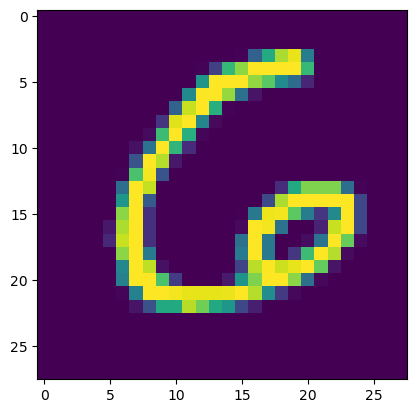

In [26]:
plt.imshow(data[2,:,:])

### Cleanup

In [29]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '55a87a3c-fe8f-4621-8395-52111d108904',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '55a87a3c-fe8f-4621-8395-52111d108904',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 10 May 2023 10:11:51 GMT'},
  'RetryAttempts': 0}}